# T015 · Binding site detection

Authors:
- adapted from Abishek Laxmanan Ravi Shankar, 2019, Volkamer Lab
- Andrea Volkamer, 2020/21, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2020/21, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

The binding site of a protein is the key to its function. In this talktorial, we introduce the concepts of computational binding site detection tools, exemplified on an EGFR structure using DoGSiteScorer from the  [protein.plus](https://proteins.plus/) web server. 
Additionally, we will compare the results to the pre-defined KLIFS binding site by calculating the percentage of residues in accordance between the two sets.

### Contents in *Theory*

* Protein binding sites
* Binding site detection
    * Methods overview
    * DoGSiteScorer
* Comparison to KLIFS pocket

### Contents in *Practical*

* Binding site detection using DoGSiteScorer
    * Job submission of structure of interest
    * Get DoGSiteScorer pocket metadata
    * Pick the most suitable pocket
    * Get best binding site file content
    * TODO: Show pocket using nglview
* Comparison between DoGSiteScorer and KLIFS pocket
    * Get DoGSiteScorer pocket residues
    * Get KLIFS pocket residues
    * Overlap of pocket residues

### References
* Prediction, Analysis, and Comparison of Active Sites [Volkamer <i>et al.</i>, (<b>2018</b>)](https://doi.org/10.1002/9783527806539.ch6g), book chapter in Applied Chemoinformatics: Achievements and Future Opportunities, Wiley
* DoGSiteScorer, [Volkamer <i>et al.</i>, <i>J.Chem.Inf.Model</i>, (<b>2012</b>), 52(2):360-372](https://pubmed.ncbi.nlm.nih.gov/22148551/)
* [ProteinsPlus](https://proteins.plus/): a web portal for structure analysis of macromolecules. [Fährrolfes <i>et al.</i>, <i>NAR</i>, (<b>2017</b>), 3;45(W1)](https://pubmed.ncbi.nlm.nih.gov/28472372/)
* [KLIFS](https://klifs.net/): a structural kinase-ligand interaction database, [Kooistra <i>et al.</i>, <i>NAR</i>, (<b>2016</b>), 4;44(D1):D365-71](https://pubmed.ncbi.nlm.nih.gov/26496949/) 

## Theory

### Protein binding sites

Most biological processes are guided through (non-)reversible binding of molecules. Given a therapeutic target associated to a specific disease, knowing its binding site(s), i.e. the key to the proteins function, is of utmost important for designing new drugs.

Depending on the given data, e.g. no protein-ligand complex structure (x-ray) is available or one is interested in allosteric sites, binding site detection algorithm come into play. Binding sites, or in the case of enzyme rather called active sites, are defined as cavities in 3-dimensional space, mostly on the surface of a protein structure, that serve as binding (docking) regions for ligands, peptides, or proteins. Therefore, the two binding partners need to be complementary concerning to shape and physico-chemical properties (like a key and a look).

![Binding site example](images/3w32_SP_0_0.png)

*Figure 1:* Example of a detected binding site for EGFR kinase (PDB: [3w32](https://www.rcsb.org/structure/3W32)) using DoGSiteScorer from [proteins.plus](https://proteins.plus). Protein shown as blue cartoon, ligand as sticks (carbons in gray) and binding site as violet cloud (largest subpocket shown).


### Binding site detection

#### Methods overview

If ligand information is available (protein-ligand complex), then the protein residues sourounding the ligand can simply be defined as pocket (e.g. using all protein residues within a predefined radius of the ligand atoms such as 6 Å). If the ligand is absent, detection tools can be used for *in silico* pocket detection. These methods can be largely grouped on the one hand into geometry- and energy-based methods as well as on the other hand in grid-based and grid-free approaches, as outlined in the Figure 1. Note that in recent years, more and more machine or deep learning based methods have been developed (see e.g. [DeepSite](https://doi.org/10.1093/bioinformatics/btx350) by Jiménez *et al.*, Bioinformatics, 2017, 33(19),3036–3042).

![Binding site detection methods](images/Figure2_DetectionMethods.png)

*Figure 2*: Binding site detection methods can be grouped into geometry-based and energy-based approaches as well as grid-based and grid-free approaches. Figure from Prediction, Analysis, and Comparison of Active Sites, [Volkamer <i>et al.</i>, (<b>2018</b>)](https://doi.org/10.1002/9783527806539.ch6g), Applied Chemoinformatics: Achievements and Future Opportunities, Wiley.

**Geometry-based approaches** analyze the shape of a molecular surface to locate cavities. They are based upon the 3D spatial arrangement of the atoms on the protein surface. **Energy-based approaches** record interactions of probes or a molecular fragment with the protein. Favorable energetic responses are thereby assigned to pockets. Both strategies can be performed on a Cartesian **grid-based** representation of the protein (i.e. checking the environment per grid point) or without (i.e. **grid-free**). 

In the following an example for each of the four categories will be shortly introduced:
* *Geometric, grid-based approach*: In [**LIGSITE**](https://doi.org/10.1016/s1093-3263(98)00002-3) (Hendlich, *et al.*, J Mol Graph Model., 1997, 15(6):359-63, 389), a Cartesian grid (e.g. 1Å grid spacing) is spanned over the protein of interest. Each grid point is then scanned in seven direction (along the X, Y and Z axes as well as the fours cubic diagonals) and the number of Protein Solvent Protein (PSP) event per point is stored (# rays restricted on both side by the protein). Finally, grid points that are buried (= have a high PSP value) are clustered to pockets.
* *Geometric, grid-free approach*: In [**SURFNET**](https://doi.org/10.1016/0263-7855(95)00073-9) (Laskowski, J Mol Graph., 1995, 13(5):323-30, 307-8), spheres are placed midway between any two pairs of atoms on the protein surface directly. In case a probe clashes with any nearby atom, its radius is reduced until no overlap occurs. The resulting probes define the cavities.
* *Energy, grid-based approach*: In [**DrugSite**](https://doi.org/10.11234/GI1990.15.2_31) (An, *et al.*, Genome Informatics, 2004, 15(2): 31–41), the protein is embedded in a Cartesian grid and carbon probes are placed on each grid point. Then, van der Waal's energies between the probe and the protein environment within 8 Å distance are calculated. Grid points with unfavorable energies, i.e. above an engery cut-off based on the mean energy and standard deviation over the whole grid, are discarded. Finally, grid points fulfilling these cut-off are merged to pockets.
* *Energy, grid-free approach*:  In **docking**-based methods, fragments (or small molecules) are docked against the protein of interest (placed and scored, for more info on Docking see talktorial T015). Pockets are then assigned based on the quantity of fragments that bind to a specific area.

#### DoGSiteScorer

In this talktorial, we will use the DoGSiteScorer functionality, available within [protein.plus](https://proteins.plus/), to detect and score the pockets of a protein of interest. Thus, it's algorithm will be explained in a bit more detail (see Figure 3 for a visual explanation).

* *Pocket Detection*: DoGSiteScorer incorporates a **geometric** and **grid-based** algorithm to detect pockets. The protein is embedded in a Cartesian grid, and each grid point is labeled as either 0 (free) or 1 (occupied), depending on if it lies within any protein atom's vdw radius. Then, an edge-detection algorithm from image processing, a **Difference of Gaussian filter** (thus the name DoGSite) is invoked to identify protrusion on the protein surface (i.e. the positions on a protein surface where the location of a sphere-like object is favorable). Based on specific cut-off criteria, grid points with the highest intensity are selected and first clustered to subpockets, then merged to pockets. 
* *Descriptor calculation*: Based on the grid representation of the respective pocket as well as the surrounding protein atoms, properties describing the pocket are derived. These include properties such as volume, surface, or depth of the pocket (calculated directly from the properties of the individual grid points) as well as hyprophobicity, number of available hydrogen bond donors/acceptors or amino acid count (derived from the neighboring protein residues).  
* *Druggability estimates*: Additionally, the tool has an inbuilt druggability predictor. Druggability can be defined as the ability of a (disease modifying) target to bind (and potentially be modulated by) low molecular weight compounds (sometimes also referred to as ligandability). In DoGSiteScorer, druggablity is predicted using a support vector machine (SVM) model, trained and tested on the freely available (non-redundant) druggability data set (NR) DD. The DD consists of 1069 targets and each target has been assigned to one of the three classes: druggable, difficult, and undruggable. See [Volkamer <i>et al.</i>, J. Chem. Inf. Model., 2012, 52, 2, 360–372](https://pubs.acs.org/doi/10.1021/ci200454v) for more detail.

![DoGSiteScorer methodology](images/3w32_DoGSite_Overview.png)

*Figure 3*: Schematic representation of the individual steps within DoGSiteScorer: A. Pocket detection, B. Descriptor calculation and C. Druggability estimation. Figure newly composed based on [Volkamer <i>et al.</i>, J. Chem. Inf. Model., 2012, 52, 2, 360–372](https://pubs.acs.org/doi/10.1021/ci200454v) and [Volkamer <i>et al.</i>, J. Chem. Inf. Model., 2010, 50, 11, 2041–2052](https://pubs.acs.org/doi/10.1021/ci100241y).


### Comparison
Once we obtain the binding site of interest from DoGSiteScorer, we can compare the results with any other method in order to validate it. Here, we compare it with the manually assigned KLIFS binding pocket for our target kinase structure using the KLIFS API (see **Talktorial T012** for more detail).

**KLIFS pocket definition** (in a nutshell):
The KLIFS (Kinase-Ligand Interaction Fingerprints and Structures) database, is a structural repository of information on over 3600 human and mouse kinase structures. KLIFS thereby enables us to do systematic comparison or analysis of the structures, chemical features, bound ligands and interactions to such of all available structures. KLIFS comes with a nomenclature of typical structural motifs within kinases (such as DFG-in/out, hinge region, ...) and maps the binding site of all known kinases 85 residues, defined via an elaborated multiple seqeuence alignment. It is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity. 

In this talktorial, we will query the KLIFS API to return the binding pocket of a specific kinase protein of interest for further analysis.

## Practical

In this practical part, we will introduce how to query the [proteins.plus](https://proteins.plus) server and do binding site detection using DoGSiteScorer functionality for our protein of interest.

Import all necessary libraries

In [1]:
from pathlib import Path
import time

import requests
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import pandas as pd
from biopandas.pdb import PandasPdb
import nglview

from opencadd.databases.klifs import setup_remote

pd.set_option('display.max_columns', 50)

Add globals to this talktorial's path (`HERE`) and its data folder (`DATA`).

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Binding site detection using DoGSiteScorer
We first define a function to query the server for a protein of interest.
Infos on the rest API can be found [here](https://proteins.plus/help/dogsite_rest).

In [3]:
def dogsitescorer_submit_with_pdbid(pdb_code, chain_id, ligand=''):
    """
    Submit PDB ID to DoGSiteScorer webserver using their API and get back URL for job location.
    
    Parameters
    ----------
    pdb_id : str 
        4-letter valid PDB ID, e.g. '3w32'.
    chain : str
        Chain ID, e.g. 'A'.
    ligand : str
        Name of ligand bound to PDB structure with pdb_id, e.g. 'W32_A_1101'. 
        Currently, the ligand name must be checked manually on the PDB website. 
        
    Returns
    -------
    str
        Job location URL for submitted query.
        
    References
    ----------
        Function is adapted from: https://github.com/volkamerlab/TeachOpenCADD/pull/3 (@jaimergp)
    """
    
    # Submit job to proteins.plus
    # For details on parameters see: https://proteins.plus/help/dogsite_rest
    r = requests.post("https://proteins.plus/api/dogsite_rest",
        json={
            "dogsite": {
                "pdbCode": pdb_code, # PDB code of protein
                "analysisDetail": "1", # 1 = subpockets
                "bindingSitePredictionGranularity": "1", # 1 = including drugablity scores
                "ligand": ligand, # if name is specified ligand coverage is calucalted
                "chain": chain_id # if chain is specified, calculation is only performed on this chain
            }
        },
        headers= {'Content-type': 'application/json', 'Accept': 'application/json'}
    )

    r.raise_for_status()
    
    return r.json()['location']

#### Job submission for structure of interest

Define the protein of interest. As an example, we chose an EGFR kinase structure, more details can be found in the respective PDB entry: [3w32](https://www.rcsb.org/structure/3W32).

In [4]:
pdb_id = "3w32"
chain_id = "A"
ligand = 'W32_A_1101'

Submit the query and return the job location for further investigation.

In [5]:
# Identifying the job location where the work is submitted to the web server
job_location = dogsitescorer_submit_with_pdbid(pdb_id, chain_id, ligand)
job_location

'https://proteins.plus/api/dogsite_rest/DgaMKhauLg4PpBwCMbmbwLCR'

In [6]:
# Wait a bit so that job can finish
time.sleep(30)

#### Get DoGSiteScorer pocket metadata
We now define a function that collects all data returned by the server and stores them in a pandas dataframe.

In [7]:
def get_dogsitescorer_metadata(job_location):
    """
    Get results from a DoGSiteScorer query, i.e. the binding sites which are found over the protein surface, 
    in the form of a table with the details about all detected pockets.

    Parameters
    ----------
    job_location : str
        Consists of the location of a finished DoGSiteScorer job on the proteins.plus web server.
    
    Returns
    -------
    pandas.DataFrame
        Table with metadata on detected binding sites. 
    """
    
    # Get job results
    result = requests.get(job_location)
    
    # Get URL of result table file
    result_file = result.json()['result_table']
    
    # Get result table
    result_table = requests.get(result_file).text
    
    # Split string into list of lists (=table)
    result_table_split = [i.split('\t') for i in result_table[:-1].split('\n')]

    # Remove spaces
    result_table_split = [[j.replace(' ', '') for j in i] for i in result_table_split]

    # Extract column names, index names, table body
    column_names = result_table_split[0]
    index_names = [i[0] for i in result_table_split[1:]]
    table = [i[1:] for i in result_table_split[1:]]

    # Convert to DataFrame
    result_table_df = pd.DataFrame(
        table,
        columns=column_names[1:],
        index=index_names
    )
    result_table_df.index.name = 'name'
    
    # Convert number strings to numeric values
    for name, data in result_table_df.iteritems():
        try:
            result_table_df[name] = pd.to_numeric(data)
        except ValueError:
            pass
    
    return result_table_df

Retrieving all the guessed pockets from DoGSiteScorer web server 

In [8]:
# A dataframe is returned containing all information
metadata = get_dogsitescorer_metadata(job_location)
metadata.head(5)

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,lid/hull,ellVol,ellc/a,ellb/a,siteAtms,accept,donor,hydrophobic_interactions,hydrophobicity,metal,Cs,Ns,Os,Ss,Xs,negAA,posAA,polarAA,apolarAA,ALA,ARG,ASN,ASP,CYS,GLN,GLU,GLY,HIS,ILE,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL,simpleScore,drugScore
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,-,-,0.13,0.67,288,86,40,71,0.36,0,198,45,41,4,0,0.10,0.13,0.24,0.53,4,5,2,5,2,2,1,5,0,3,12,3,2,3,3,1,2,1,1,5,0.63,0.810023
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,-,-,0.14,0.22,131,35,13,25,0.34,0,95,16,17,3,0,0.03,0.10,0.28,0.59,1,2,1,1,2,1,0,2,0,2,7,1,2,2,1,0,2,0,0,2,0.59,0.620201
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,-,-,0.17,0.25,51,17,9,10,0.28,0,36,6,7,2,0,0.08,0.17,0.25,0.50,1,1,0,1,1,1,0,0,0,0,3,1,1,0,0,0,1,0,0,1,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,-,-,0.45,0.55,48,17,8,12,0.32,0,31,8,8,1,0,0.17,0.25,0.08,0.50,0,2,0,1,0,0,1,1,0,0,2,1,1,1,0,0,0,0,0,2,0.13,0.195695
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,-,-,0.23,0.37,48,16,8,14,0.37,0,32,8,8,0,0,0.14,0.14,0.36,0.36,1,1,1,2,0,0,0,3,0,0,1,1,0,1,1,1,0,0,0,1,0.13,0.168845


#### Pick the most suitable pocket
The pockets are initially sorted by the volume of the respective pocket.
We want to have a deeper look at the pocket that contains the ligand (see ligand coverage column ``lig_cov``) and which is covered by the ligand the most (pocket coverage ``poc_cov``). 

In [9]:
# For clarity we drop a few columns
col_to_drop = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','lid/hull','ellVol', 'Cs','Ns','Os','Ss','Xs']
metadata.drop(col_to_drop, axis=1, inplace=True)

In [10]:
# Sort the obtained binding site by your column of interest
metadata.sort_values(by=['lig_cov', 'poc_cov'], ascending=False).head(5)

,lig_cov,poc_cov,lig_name,volume,enclosure,surface,depth,surf/vol,ellc/a,ellb/a,siteAtms,accept,donor,hydrophobic_interactions,hydrophobicity,metal,negAA,posAA,polarAA,apolarAA,simpleScore,drugScore
name,,,,,,,,,,,,,,,,,,,,,,
P_0_0,85.48,73.90,W32_A_1101,599.23,0.06,540.06,17.51,0.901257,0.14,0.22,131,35,13,25,0.34,0,0.03,0.10,0.28,0.59,0.59,0.620201
P_0,85.48,31.22,W32_A_1101,1422.66,0.10,1673.75,19.26,1.176493,0.13,0.67,288,86,40,71,0.36,0,0.10,0.13,0.24,0.53,0.63,0.810023
P_0_3,6.45,0.29,W32_A_1101,175.30,0.15,297.42,9.29,1.696634,0.23,0.37,48,16,8,14,0.37,0,0.14,0.14,0.36,0.36,0.13,0.168845
P_0_1,3.23,0.44,W32_A_1101,201.73,0.08,381.07,11.36,1.889010,0.17,0.25,51,17,9,10,0.28,0,0.08,0.17,0.25,0.50,0.17,0.174816
P_0_2,0.00,0.00,W32_A_1101,185.60,0.17,282.00,9.35,1.519397,0.45,0.55,48,17,8,12,0.32,0,0.17,0.25,0.08,0.50,0.13,0.195695


**Note**: We decided here to select the pocket with the best ligand and pocket coverage to have a precise description of the pocket for our later comparison. In other drug design scenarios, you might want to simply sort by drugScore (``metadata.sort_values(by='drugScore', ascending=False)``) or other (e.g. ``volume`` or ``simpleScore``).

We define a function that returns us the id of the pocket that fullfills our sorting criterion.

In [11]:
def select_best_pocket(metadata, sorted_by='drugScore'):
    """
    This function uses the defined sorting parameter to identify 
    the best pocket among the obtained pockets.
    
    Parameters
    ----------
    metadata : pd.DataFrame
        Pockets retrieved from the DoGSiteScorer website
        
    by : str
        Method name(s) to sort table by (default is to sort by drugScore).
        
    Returns 
    -------
    str
        Best binding site name.
    """
    
    by_methods = ['drugScore', 'volume', 'simpleScore', 'lig_cov', 'poc_cov']
    
    # Sort by theselected method
    if all(elem in by_methods for elem in sorted_by):
        sorted_pocket = metadata.sort_values(sorted_by, ascending=False)
    else:
        raise ValueError(f'Selection method not in list: {", ".join(by_methods)}')
                         
    # Get name of best pocket
    best_pocket_name = sorted_pocket.iloc[0, :].name     
        
    return best_pocket_name

In [12]:
# Get the name of the best pocket
best_pocket = select_best_pocket(metadata, ['lig_cov', 'poc_cov'])
best_pocket

'P_0_0'

#### Get binding site file content

We define two helper functions to first get the URL for all pocket PDB files and then we only process the file further for our pocket of interest.

In [13]:
def get_url_for_pockets(job_location):
    """
    Get all pocket file locations for a finished DoGSiteScorer job.
    
    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    
    Returns
    -------
    list
        List of all pocket file URLs.
    """
    
    # Get job results
    result = requests.get(job_location)
    
    # Get residues
    return result.json()['residues']

In [14]:
def get_best_pocket_location(job_location, best_pocket):
    """
    Get the best binding site file location.
    
    Parameters
    ----------
    job_location : str
        URL of finished job submitted to the DoGSiteScorer web server.
    best_pocket : str
        Selected pocket id.

    Returns
    ------
    str
        URL of selected pocket file on the DoGSiteScorer web server.
    """
    result = []
    
    # Get URL for all PDB files
    pocket_files = get_url_for_pockets(job_location)
    
    for pocket_file in pocket_files:
        
        if f'{best_pocket}_res' in pocket_file:
            result.append(pocket_file)
            
    if len(result) > 1:
        raise TypeError(f'Multiple strings detected: {", ".join(result)}.')
    elif len(result) == 0:
        raise TypeError(f'No string detected.')
    else:
        pass
            
    return result[0]

In [15]:
# Get URL for PDB file containing the best pocket
selected_pocket_url = get_best_pocket_location(job_location, best_pocket)
selected_pocket_url

'https://proteins.plus/results/dogsite/DgaMKhauLg4PpBwCMbmbwLCR/3w32_P_0_0_res.pdb'

#### TODO: Show pocket using nglview
And maybe comment on the respective descriptors.

In [16]:
# Get pocket coordinates from proteins.plus
result = requests.get(selected_pocket_url)
# Save text to temporary file
temp_file_path = DATA / "pocket.pdb"
with open(temp_file_path, "w") as f:
    f.write(result.text)
# Set up pocket visualization
viewer = nglview.show_structure_file(str(temp_file_path))
viewer.add_representation("ball+stick")
viewer.center()
# Remove temporary file
temp_file_path.unlink()
# Show pocket
viewer

NGLWidget()

In [17]:
viewer.render_image(trim=True, transparent=True);

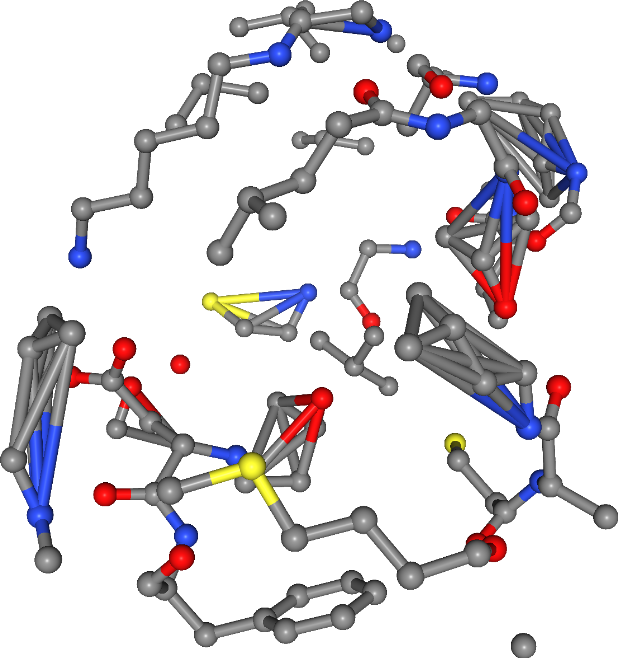

In [18]:
viewer._display_image()

### Comparison between DoGSiteScorer and KLIFS pocket

#### Get DoGSiteScorer pocket residues
Since we want to compare the automatically predicted pocket, with the manually assigned KLIFS pocket, we need to identify the pocket residues.

In [19]:
def get_pocket_residues(pocket_url):
    """
    Gets residue IDs and names of a pocket.
    
    Parameters
    ----------
    pocket_url : str
        URL of selected pocket file on the DoGSiteScorer web server.
        
    Returns
    -------
    pandas.DataFrame
        Table of residues names and IDs for the selected binding site.
    """
    
    # Retrieve PDB file content from URL
    result = requests.get(pocket_url)

    # Get content of PDB file  
    pdb_residues = result.text
    
    # Load PDB format as DataFrame
    ppdb = PandasPdb()
    pdb_df = ppdb._construct_df(pdb_residues.splitlines(True))['ATOM']
    
    # Drop duplicates
    # PDB file contains per atom entries, we only need per residue info
    pdb_df.sort_values("residue_number", inplace = True)
    pdb_df.drop_duplicates(subset ="residue_number", 
                     keep = 'first', inplace = True) 
    
    return pdb_df[['residue_number', 'residue_name']]

In [20]:
# Get residues of selected pocket
dogsite_pocket_residues_df = get_pocket_residues(selected_pocket_url)
dogsite_pocket_residues_df.head()

,residue_number,residue_name
0,718,LEU
4,726,VAL
11,743,ALA
12,744,ILE
20,745,LYS


#### Get KLIFS pocket residues

We are using the `opencadd.databases.klifs` module to extract the binding site residues (PDB residue numbering) as defined in the KLIFS database.

Please refer to __Talktorial T012__ for detailed information about KLIFS and the `opencadd.databases.klifs` module usage.

In [21]:
session = setup_remote()

In [22]:
# Get first structure KLIFS ID associated with PDB ID
structures = session.structures.by_structure_pdb_id(pdb_id)
structure_klifs_id = structures["structure.klifs_id"].iloc[0]
# Get the structure's pocket
klifs_pocket_df = session.pockets.by_structure_klifs_id(structure_klifs_id)
klifs_pocket_df.head()

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,716,I.1,I,khaki
1,2,717,I.2,I,khaki
2,3,718,I.3,I,khaki
3,4,719,g.l.4,g.l,green
4,5,720,g.l.5,g.l,green


#### Overlap of pocket residues

In [23]:
dogsite_pocket_residues=dogsite_pocket_residues_df['residue_number'].to_list()
print(f'DoGSiteScorer pocket with {len(dogsite_pocket_residues)} detected.')
#convert klifs residue entires from string to int
klifs_pocket_df['residue.id']=pd.to_numeric(klifs_pocket_df['residue.id'])
klifs_pocket_residues = klifs_pocket_df['residue.id'].to_list()#
print(f'KLIFS pocket with {len(klifs_pocket_residues)} detected.')

DoGSiteScorer pocket with 29 detected.
KLIFS pocket with 85 detected.


In [24]:
overlap=set.intersection(set(dogsite_pocket_residues), set(klifs_pocket_residues))
print(f'Overlap between the two residue sets: {len(overlap)}.')

Overlap between the two residue sets: 27.


Plot the overlap as Venn diagram

Residue overlap between the two methods.


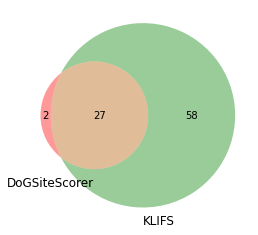

In [25]:
print(f'Residue overlap between the two methods.')
venn2([set(dogsite_pocket_residues), set(klifs_pocket_residues)], set_labels = ('DoGSiteScorer', 'KLIFS'))
plt.show()

As we can see, the subpocket we choose from DoGSiteScorer is very precise, 27 of 29 residues do overlap with the KLIFS definition.
Out of interest, we can also do the same comparison using the pocket ``P_0`` (instead of subpocket ``P_0_0``) to see how that compares to KLIFS.

In [26]:
# Get info for largest DoGSiteScorer pocket P_0
poc_id ='P_0'
dogsite_pocket_residues_df_p0 = get_pocket_residues(get_best_pocket_location(job_location, poc_id))
dogsite_pocket_residues_p0=dogsite_pocket_residues_df_p0['residue_number'].to_list()
print(f'DoGSiteScorer pocket P0 with {len(dogsite_pocket_residues_p0)} detected.')

DoGSiteScorer pocket P0 with 62 detected.


Residue overlap between the two methods using P0.


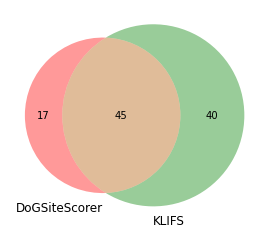

In [27]:
print(f'Residue overlap between the two methods using P0.')
venn2([set(dogsite_pocket_residues_p0), set(klifs_pocket_residues)], set_labels = ('DoGSiteScorer', 'KLIFS'))
plt.show()

## Discussion

We introduced the the idea of binding site detection algorithms here, exemplified on DoGSiteScorer, which can be queried through the [proteins.plus](https://proteins.plus) server.
Besides investigating into the main (known) binding site, as exemplified above, one can use the predicted pockets to initiate drug design campaigns against a novel, e.g. allosteric or less explored, pockets.

Potential shortcomings: Such algorithms detect the pockets based on a given protein structure (x-ray), so if another structure of the same protein is available, applying the algorithm to that structure might lead to (slightly) different pockets due to e.g. conformational changes induced by the bound ligand. Also differences between apo and holo structures do affect the predictions.

## Quiz

1. What techniques can be invoked to automatically detect pockets on the protein surface?
2. What are advantages and disadvantages of automatic binding site detection algorithms?
3. Try another protein EGFR kinase structure and check the overlap between the predicted residues.